In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install netcdf4
!pip install geopandas
!pip install rioxarray

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import rioxarray
from geopandas import read_file as gpd_read_file

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
!pip install importlib-metadata==4.13
!pip install geopandas
!pip install rasterio
!pip install scipy
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.2.0
    Uninstalling importlib-metadata-5.2.0:
      Successfully uninstalled importlib-metadata-5.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#CC = xr.open_dataset("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/CC.nc")
CC = xr.open_dataset("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/CC.nc")
CC

<xarray.Dataset>
Dimensions:    (longitude: 1422, latitude: 1982, z: 12)
Coordinates:
  * longitude  (longitude) float64 -81.4 -81.39 -81.38 ... -67.21 -67.2 -67.19
  * latitude   (latitude) float64 1.22 1.21 1.2 1.19 ... -18.57 -18.58 -18.59
  * z          (z) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    crs        int32 ...
    variable   (z, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.3-13)
    date:         2021-06-17 23:13:15

In [7]:
CC=CC.rename({"z": "time"})
CC

<xarray.Dataset>
Dimensions:    (longitude: 1422, latitude: 1982, time: 12)
Coordinates:
  * longitude  (longitude) float64 -81.4 -81.39 -81.38 ... -67.21 -67.2 -67.19
  * latitude   (latitude) float64 1.22 1.21 1.2 1.19 ... -18.57 -18.58 -18.59
  * time       (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    crs        int32 ...
    variable   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.3-13)
    date:         2021-06-17 23:13:15

In [8]:
def xr_crop(shp_i, netcdf_i):
  
  # get box
  #crop hjace un corte en el cuadrante como un where
  box_i = shp_i.total_bounds# te da el cuadrante del del shapefile 
  
  # crop based on box
  #para utilizar el where
  #se esta definiendo los boxsiuads
  crop_netcdf_i = netcdf_i.where((netcdf_i["longitude"] > box_i[0]) & # min lon
                                 (netcdf_i["longitude"] < box_i[2]) & # max lon
                                 (netcdf_i["latitude"] > box_i[1]) & # min lat
                                 (netcdf_i["latitude"] < box_i[3]), # max lat
                                 drop = True) #es para que se saque todo el area que no nos interesa
  
  return crop_netcdf_i

def xr_shp_to_grid(shp_i, netcdf_array):

  #conversion de shpafile a un  dato grillado 
  
  # get real box
  shp_i_geometry = shp_i.geometry

  # adding crs #creating xarray dataset
  mask = netcdf_array.rio.set_crs(shp_i.crs)

  # "rasterizing"
  #se denomina como rasterización, se hace un clip para un shp determinado
  mask = mask.rio.clip(shp_i_geometry, drop = True)

  # making "True/False" values
  #coinciden los puntos de grilla con los datos del punto de grilla
  mask.values[~np.isnan(mask.values)] = 1 #creo que se cambia de los valores que tienen valores por uno 
  #0 son los que no coincida con los griññadp 
  #1 preserva los puntos de pixles de cada uno de los puntos
  
  return mask.drop(["time"]) #se quita el time y el spatial_ref
#xrcrop :: como el where te hace un corte de un cuadrado
#xr_mask :: corte en base del poligono

#netcdf_i ->dato grillado
#shp_i -> shapefile
#grid mask -> mask
def xr_mask(grid_mask, netcdf_i):
  # masking
  #se hace un crop en base al mask gr
  mask_netcdf_i = netcdf_i.where(grid_mask == True)

  return mask_netcdf_i

In [9]:
#shp_peru = gpd.read_file("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/shps/Departamentos.shp")
shp_peru = gpd.read_file("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/shps/Departamentos.shp")
shp_peru.head()

,DEPCOD,DEPNOM,geometry
0,01,AMAZONAS,"POLYGON ((-77.71584 -5.10859, -77.71561 -5.108..."
1,02,ANCASH,"POLYGON ((-77.43826 -8.41625, -77.43879 -8.419..."
2,03,APURIMAC,"POLYGON ((-73.51174 -13.38481, -73.50822 -13.3..."
3,04,AREQUIPA,"POLYGON ((-71.89395 -14.78905, -71.89342 -14.7..."
4,05,AYACUCHO,"POLYGON ((-73.74697 -13.75935, -73.74495 -13.7..."


In [10]:
CC=CC.rio.set_crs(shp_peru.crs)
CC

<xarray.Dataset>
Dimensions:    (longitude: 1422, latitude: 1982, time: 12)
Coordinates:
  * longitude  (longitude) float64 -81.4 -81.39 -81.38 ... -67.21 -67.2 -67.19
  * latitude   (latitude) float64 1.22 1.21 1.2 1.19 ... -18.57 -18.58 -18.59
  * time       (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    crs        int32 ...
    variable   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.3-13)
    date:         2021-06-17 23:13:15

In [11]:
shp_regiones = gpd.read_file("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/shps/areas naturales del peru/region natural_geogpsperu_JuanPabloSuyoPomalia.shp")
shp_regiones

,OBJECTID,GlobalID,Escala,Fuente,Cod_RegNat,Nm_RegNat,SHAPE_Leng,SHAPE_Area,contacto,web,whatsapp,geometry
0,1,{4DB64834-22F3-492A-8461-71DE7B0B6394},0,OFICIO N Â° 287-2016-INEI/DNCE-DECG,2,Sierra,87.894629,31.486141,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"MULTIPOLYGON (((-74.72973 -11.61102, -74.72932..."
1,2,{8F2361F2-9CE0-44F5-8210-D3A8DFAB7A41},0,OFICIO N Â° 287-2016-INEI/DNCE-DECG,3,Selva,92.589739,62.876535,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-69.11407 -14.48779, -69.11434 -14.4..."
2,3,{D2806CDD-429B-4606-A38B-EAB1DFBB7845},0,OFICIO N Â° 287-2016-INEI/DNCE-DECG,1,Costa,75.671063,12.250577,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"MULTIPOLYGON (((-79.80161 -4.48881, -79.80155 ..."


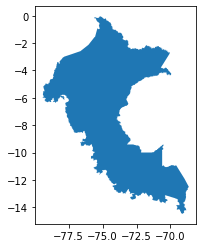

In [12]:
shp_regselva=shp_regiones.iloc[[1]]
shp_regselva.plot()

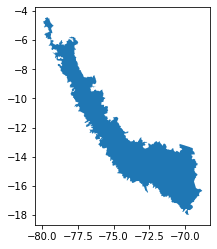

In [13]:
shp_regsierra=shp_regiones.iloc[[0]]
shp_regsierra.plot()

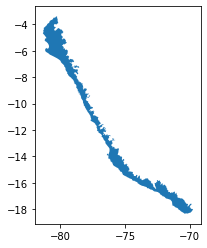

In [14]:
shp_regcosta=shp_regiones.iloc[[2]]
shp_regcosta.plot()

In [15]:
CC_croped=xr_crop(shp_i=shp_regselva,netcdf_i=CC)
#shape to grid
CC_grid=xr_shp_to_grid(shp_i = shp_regselva, netcdf_array = CC.variable.isel(time=1))
#make a mask
CC_MASK_SELVA=xr_mask(grid_mask=CC_grid, netcdf_i=CC_croped)

In [16]:
CC_croped=xr_crop(shp_i=shp_regsierra,netcdf_i=CC)
#shape to grid
CC_grid=xr_shp_to_grid(shp_i = shp_regsierra, netcdf_array = CC.variable.isel(time=1))
#make a mask
CC_MASK_SIERRA=xr_mask(grid_mask=CC_grid, netcdf_i=CC_croped)

In [17]:
CC_croped=xr_crop(shp_i=shp_regcosta,netcdf_i=CC)
#shape to grid
CC_grid=xr_shp_to_grid(shp_i = shp_regcosta, netcdf_array = CC.variable.isel(time=1))
#make a mask
CC_MASK_COSTA=xr_mask(grid_mask=CC_grid, netcdf_i=CC_croped)

In [18]:
CC_MASK_SELVA=CC_MASK_SELVA.drop_vars("crs")
CC_MASK_SELVA

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 1445, longitude: 1076)
Coordinates:
  * longitude  (longitude) float64 -79.41 -79.4 -79.39 ... -68.68 -68.67 -68.66
  * latitude   (latitude) float64 -0.04 -0.05 -0.06 ... -14.46 -14.47 -14.48
  * time       (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    variable   (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.3-13)
    date:         2021-06-17 23:13:15

In [19]:
CC_MASK_SIERRA=CC_MASK_SIERRA.drop_vars("crs")
CC_MASK_SIERRA

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 1355, longitude: 1111)
Coordinates:
  * longitude  (longitude) float64 -79.92 -79.91 -79.9 ... -68.84 -68.83 -68.82
  * latitude   (latitude) float64 -4.44 -4.45 -4.46 ... -17.96 -17.97 -17.98
  * time       (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    variable   (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.3-13)
    date:         2021-06-17 23:13:15

In [20]:
CC_MASK_COSTA=CC_MASK_COSTA.drop_vars("crs")
CC_MASK_COSTA

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 1495, longitude: 1157)
Coordinates:
  * longitude  (longitude) float64 -81.32 -81.31 -81.3 ... -69.78 -69.77 -69.76
  * latitude   (latitude) float64 -3.4 -3.41 -3.42 ... -18.32 -18.33 -18.34
  * time       (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    variable   (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.3-13)
    date:         2021-06-17 23:13:15

In [21]:
PISCOpp = xr.open_dataset("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/PISCO_precipitation/PISCOp.nc",decode_times=False)
PISCOpp

<xarray.Dataset>
Dimensions:  (T: 13149, Y: 198, X: 133)
Coordinates:
  * T        (T) float32 7.672e+03 7.672e+03 7.674e+03 ... 2.082e+04 2.082e+04
  * Y        (Y) float32 0.95 0.85 0.75 0.65 ... -18.45 -18.55 -18.65 -18.75
  * X        (X) float32 -81.25 -81.15 -81.05 -80.95 ... -68.25 -68.15 -68.05
Data variables:
    Prec     (T, Y, X) float32 ...

In [22]:
PISCOpp=PISCOpp.rename({"X": "longitude", "Y": "latitude", "T": "time"})
PISCOpp["time"]=pd.date_range("1981-01-01", freq='D',periods=13149)
PISCOpp_monthly = PISCOpp.resample(time="1M").sum(dim="time", skipna=False)
PISCOpp_monthly=PISCOpp_monthly.sel(time=slice("1981-01-31T00:00:00.000000000","2010-12-31T00:00:00.000000000"))
PISCOpp_monthly=PISCOpp_monthly.Prec.groupby(PISCOpp_monthly.time.dt.month).mean(dim="time")
PISCOpp_monthly

<xarray.DataArray 'Prec' (month: 12, latitude: 198, longitude: 133)>
array([[[        nan,         nan,         nan, ..., 254.43633  ,
         186.50539  , 181.91478  ],
        [        nan,         nan,         nan, ..., 279.18347  ,
         218.8042   , 212.44197  ],
        [        nan,         nan,         nan, ..., 316.52478  ,
         265.39374  , 242.38524  ],
        ...,
        [        nan,         nan,         nan, ..., 103.564674 ,
         103.4132   , 104.187935 ],
        [        nan,         nan,         nan, ..., 109.35368  ,
         109.11711  , 102.51998  ],
        [        nan,         nan,         nan, ..., 100.39052  ,
          92.535904 ,  86.249115 ]],

       [[        nan,         nan,         nan, ..., 243.25998  ,
         195.26056  , 190.00777  ],
        [        nan,         nan,         nan, ..., 262.30112  ,
         217.46158  , 225.59161  ],
        [        nan,         nan,         nan, ..., 288.42093  ,
         245.23915  , 234.22023  ],
...
        [        nan,         nan,         nan, ...,   1.9999167,
           2.1503174,   2.3773158],
        [        nan,         nan,         nan, ...,   2.1788898,
           2.3825338,   5.2847934],
        [        nan,         nan,         nan, ...,   5.2444363,
           5.945836 ,   5.9209833]],

       [[        nan,         nan,         nan, ..., 250.3825   ,
         401.9342   , 530.22144  ],
        [        nan,         nan,         nan, ..., 282.54242  ,
         371.6768   , 429.57794  ],
        [        nan,         nan,         nan, ..., 290.9058   ,
         309.5418   , 292.50342  ],
        ...,
        [        nan,         nan,         nan, ...,  27.18387  ,
          21.806078 ,  23.15051  ],
        [        nan,         nan,         nan, ...,  19.574541 ,
          19.573023 ,  25.603233 ],
        [        nan,         nan,         nan, ...,  21.329048 ,
          24.225481 ,  29.258165 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [23]:
PISCOpp_monthly=PISCOpp_monthly.rename({"month": "time"})
PISCOpp_monthly

<xarray.DataArray 'Prec' (time: 12, latitude: 198, longitude: 133)>
array([[[        nan,         nan,         nan, ..., 254.43633  ,
         186.50539  , 181.91478  ],
        [        nan,         nan,         nan, ..., 279.18347  ,
         218.8042   , 212.44197  ],
        [        nan,         nan,         nan, ..., 316.52478  ,
         265.39374  , 242.38524  ],
        ...,
        [        nan,         nan,         nan, ..., 103.564674 ,
         103.4132   , 104.187935 ],
        [        nan,         nan,         nan, ..., 109.35368  ,
         109.11711  , 102.51998  ],
        [        nan,         nan,         nan, ..., 100.39052  ,
          92.535904 ,  86.249115 ]],

       [[        nan,         nan,         nan, ..., 243.25998  ,
         195.26056  , 190.00777  ],
        [        nan,         nan,         nan, ..., 262.30112  ,
         217.46158  , 225.59161  ],
        [        nan,         nan,         nan, ..., 288.42093  ,
         245.23915  , 234.22023  ],
...
        [        nan,         nan,         nan, ...,   1.9999167,
           2.1503174,   2.3773158],
        [        nan,         nan,         nan, ...,   2.1788898,
           2.3825338,   5.2847934],
        [        nan,         nan,         nan, ...,   5.2444363,
           5.945836 ,   5.9209833]],

       [[        nan,         nan,         nan, ..., 250.3825   ,
         401.9342   , 530.22144  ],
        [        nan,         nan,         nan, ..., 282.54242  ,
         371.6768   , 429.57794  ],
        [        nan,         nan,         nan, ..., 290.9058   ,
         309.5418   , 292.50342  ],
        ...,
        [        nan,         nan,         nan, ...,  27.18387  ,
          21.806078 ,  23.15051  ],
        [        nan,         nan,         nan, ...,  19.574541 ,
          19.573023 ,  25.603233 ],
        [        nan,         nan,         nan, ...,  21.329048 ,
          24.225481 ,  29.258165 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

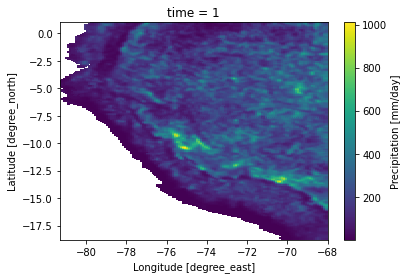

In [24]:
PISCOpp_monthly.isel(time=0).plot()

In [25]:
PISCOpp_monthly.rio.set_crs(shp_regselva.crs)
PISCOPP_CRP=xr_crop(shp_i=shp_regselva,netcdf_i=PISCOpp_monthly)
#shape to grid
PISCO_PP_grid=xr_shp_to_grid(shp_i = shp_regselva, netcdf_array = PISCOpp_monthly.isel(time=0))
#make a mask
PISCO_PP_MASK_SELVA=xr_mask(grid_mask=PISCO_PP_grid, netcdf_i=PISCOPP_CRP)

In [26]:
PISCOpp_monthly.rio.set_crs(shp_regsierra.crs)
PISCOPP_CRP=xr_crop(shp_i=shp_regsierra,netcdf_i=PISCOpp_monthly)
#shape to grid
PISCO_PP_grid=xr_shp_to_grid(shp_i = shp_regsierra, netcdf_array = PISCOpp_monthly.isel(time=0))
#make a mask
PISCO_PP_MASK_SIERRA=xr_mask(grid_mask=PISCO_PP_grid, netcdf_i=PISCOPP_CRP)

In [27]:
PISCOpp_monthly.rio.set_crs(shp_regcosta.crs)
PISCOPP_CRP=xr_crop(shp_i=shp_regcosta,netcdf_i=PISCOpp_monthly)
#shape to grid
PISCO_PP_grid=xr_shp_to_grid(shp_i = shp_regcosta, netcdf_array = PISCOpp_monthly.isel(time=0))
#make a mask
PISCO_PP_MASK_COSTA=xr_mask(grid_mask=PISCO_PP_grid, netcdf_i=PISCOPP_CRP)

In [28]:
PISCO_PP_MASK_SELVA

<xarray.DataArray 'Prec' (time: 12, latitude: 144, longitude: 107)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude     (latitude) float32 -0.15 -0.25 -0.35 ... -14.25 -14.35 -14.45
  * longitude    (longitude) float32 -79.35 -79.25 -79.15 ... -68.85 -68.75
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int64 0
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [29]:
PISCO_PP_MASK_SELVA=PISCO_PP_MASK_SELVA.drop_vars("spatial_ref")
PISCO_PP_MASK_SELVA

<xarray.DataArray 'Prec' (time: 12, latitude: 144, longitude: 107)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -0.15 -0.25 -0.35 ... -14.25 -14.35 -14.45
  * longitude  (longitude) float32 -79.35 -79.25 -79.15 ... -68.95 -68.85 -68.75
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [30]:
PISCO_PP_MASK_SIERRA=PISCO_PP_MASK_SIERRA.drop_vars("spatial_ref")
PISCO_PP_MASK_SIERRA

<xarray.DataArray 'Prec' (time: 12, latitude: 136, longitude: 111)>
array([[[       nan,        nan, 120.55688 , ...,        nan,
                nan,        nan],
        [       nan, 140.1603  , 145.07599 , ...,        nan,
                nan,        nan],
        [       nan, 167.87347 , 170.26411 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan, 163.53653 , ...,        nan,
                nan,        nan],
        [       nan, 238.26662 , 233.48114 , ...,        nan,
                nan,        nan],
        [       nan, 262.88425 , 270.9461  , ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,  88.20768 , ...,        nan,
                nan,        nan],
        [       nan,  80.11398 ,  92.953   , ...,        nan,
                nan,        nan],
        [       nan,  99.65112 ,  98.65717 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -4.45 -4.55 -4.65 ... -17.75 -17.85 -17.95
  * longitude  (longitude) float32 -79.85 -79.75 -79.65 ... -69.05 -68.95 -68.85
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [31]:
PISCO_PP_MASK_COSTA=PISCO_PP_MASK_COSTA.drop_vars("spatial_ref")
PISCO_PP_MASK_COSTA

<xarray.DataArray 'Prec' (time: 12, latitude: 149, longitude: 115)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  6.9043202 ,
         11.658789  , 14.872147  ],
        [        nan,         nan,         nan, ...,  2.6914685 ,
          7.1521244 , 12.616795  ],
        [        nan,         nan,         nan, ...,  2.5639064 ,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,  0.44271234,
          0.5018339 ,  0.6379173 ],
        [        nan,         nan,         nan, ...,  0.48854017,
          0.57036406,  0.6599199 ],
        [        nan,         nan,         nan, ...,  0.62915343,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  1.1387844 ,
          1.3120368 ,  3.5610049 ],
        [        nan,         nan,         nan, ...,  1.1596566 ,
          1.2903053 ,  1.5259672 ],
        [        nan,         nan,         nan, ...,  1.2072009 ,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -3.45 -3.55 -3.65 ... -18.05 -18.15 -18.25
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -70.05 -69.95 -69.85
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [32]:
CC_MASK_SELVA_interpolated=CC_MASK_SELVA.variable.interp_like(PISCO_PP_MASK_SELVA,method="nearest")
CC_MASK_SELVA_interpolated=CC_MASK_SELVA_interpolated.to_dataset()

In [33]:
CC_MASK_SELVA_interpolated

<xarray.Dataset>
Dimensions:    (longitude: 107, latitude: 144, time: 12)
Coordinates:
  * longitude  (longitude) float32 -79.35 -79.25 -79.15 ... -68.95 -68.85 -68.75
  * latitude   (latitude) float32 -0.15 -0.25 -0.35 ... -14.25 -14.35 -14.45
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    variable   (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [34]:
CC_MASK_SIERRA_interpolated=CC_MASK_SIERRA.variable.interp_like(PISCO_PP_MASK_SIERRA,method="nearest")
CC_MASK_SIERRA_interpolated=CC_MASK_SIERRA_interpolated.to_dataset()

In [35]:
CC_MASK_SIERRA_interpolated

<xarray.Dataset>
Dimensions:    (longitude: 111, latitude: 136, time: 12)
Coordinates:
  * longitude  (longitude) float32 -79.85 -79.75 -79.65 ... -69.05 -68.95 -68.85
  * latitude   (latitude) float32 -4.45 -4.55 -4.65 ... -17.75 -17.85 -17.95
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    variable   (time, latitude, longitude) float32 nan nan 78.3 ... nan nan nan

In [36]:
CC_MASK_COSTA_interpolated=CC_MASK_COSTA.variable.interp_like(PISCO_PP_MASK_COSTA,method="nearest")
CC_MASK_COSTA_interpolated=CC_MASK_COSTA_interpolated.to_dataset()

In [37]:
CC_MASK_COSTA_interpolated

<xarray.Dataset>
Dimensions:    (longitude: 115, latitude: 149, time: 12)
Coordinates:
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -70.05 -69.95 -69.85
  * latitude   (latitude) float32 -3.45 -3.55 -3.65 ... -18.05 -18.15 -18.25
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    variable   (time, latitude, longitude) float32 nan nan nan ... 18.77 nan nan

In [38]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import seaborn as sns
from matplotlib.dates import DateFormatter

In [39]:
sns.set_context("poster")

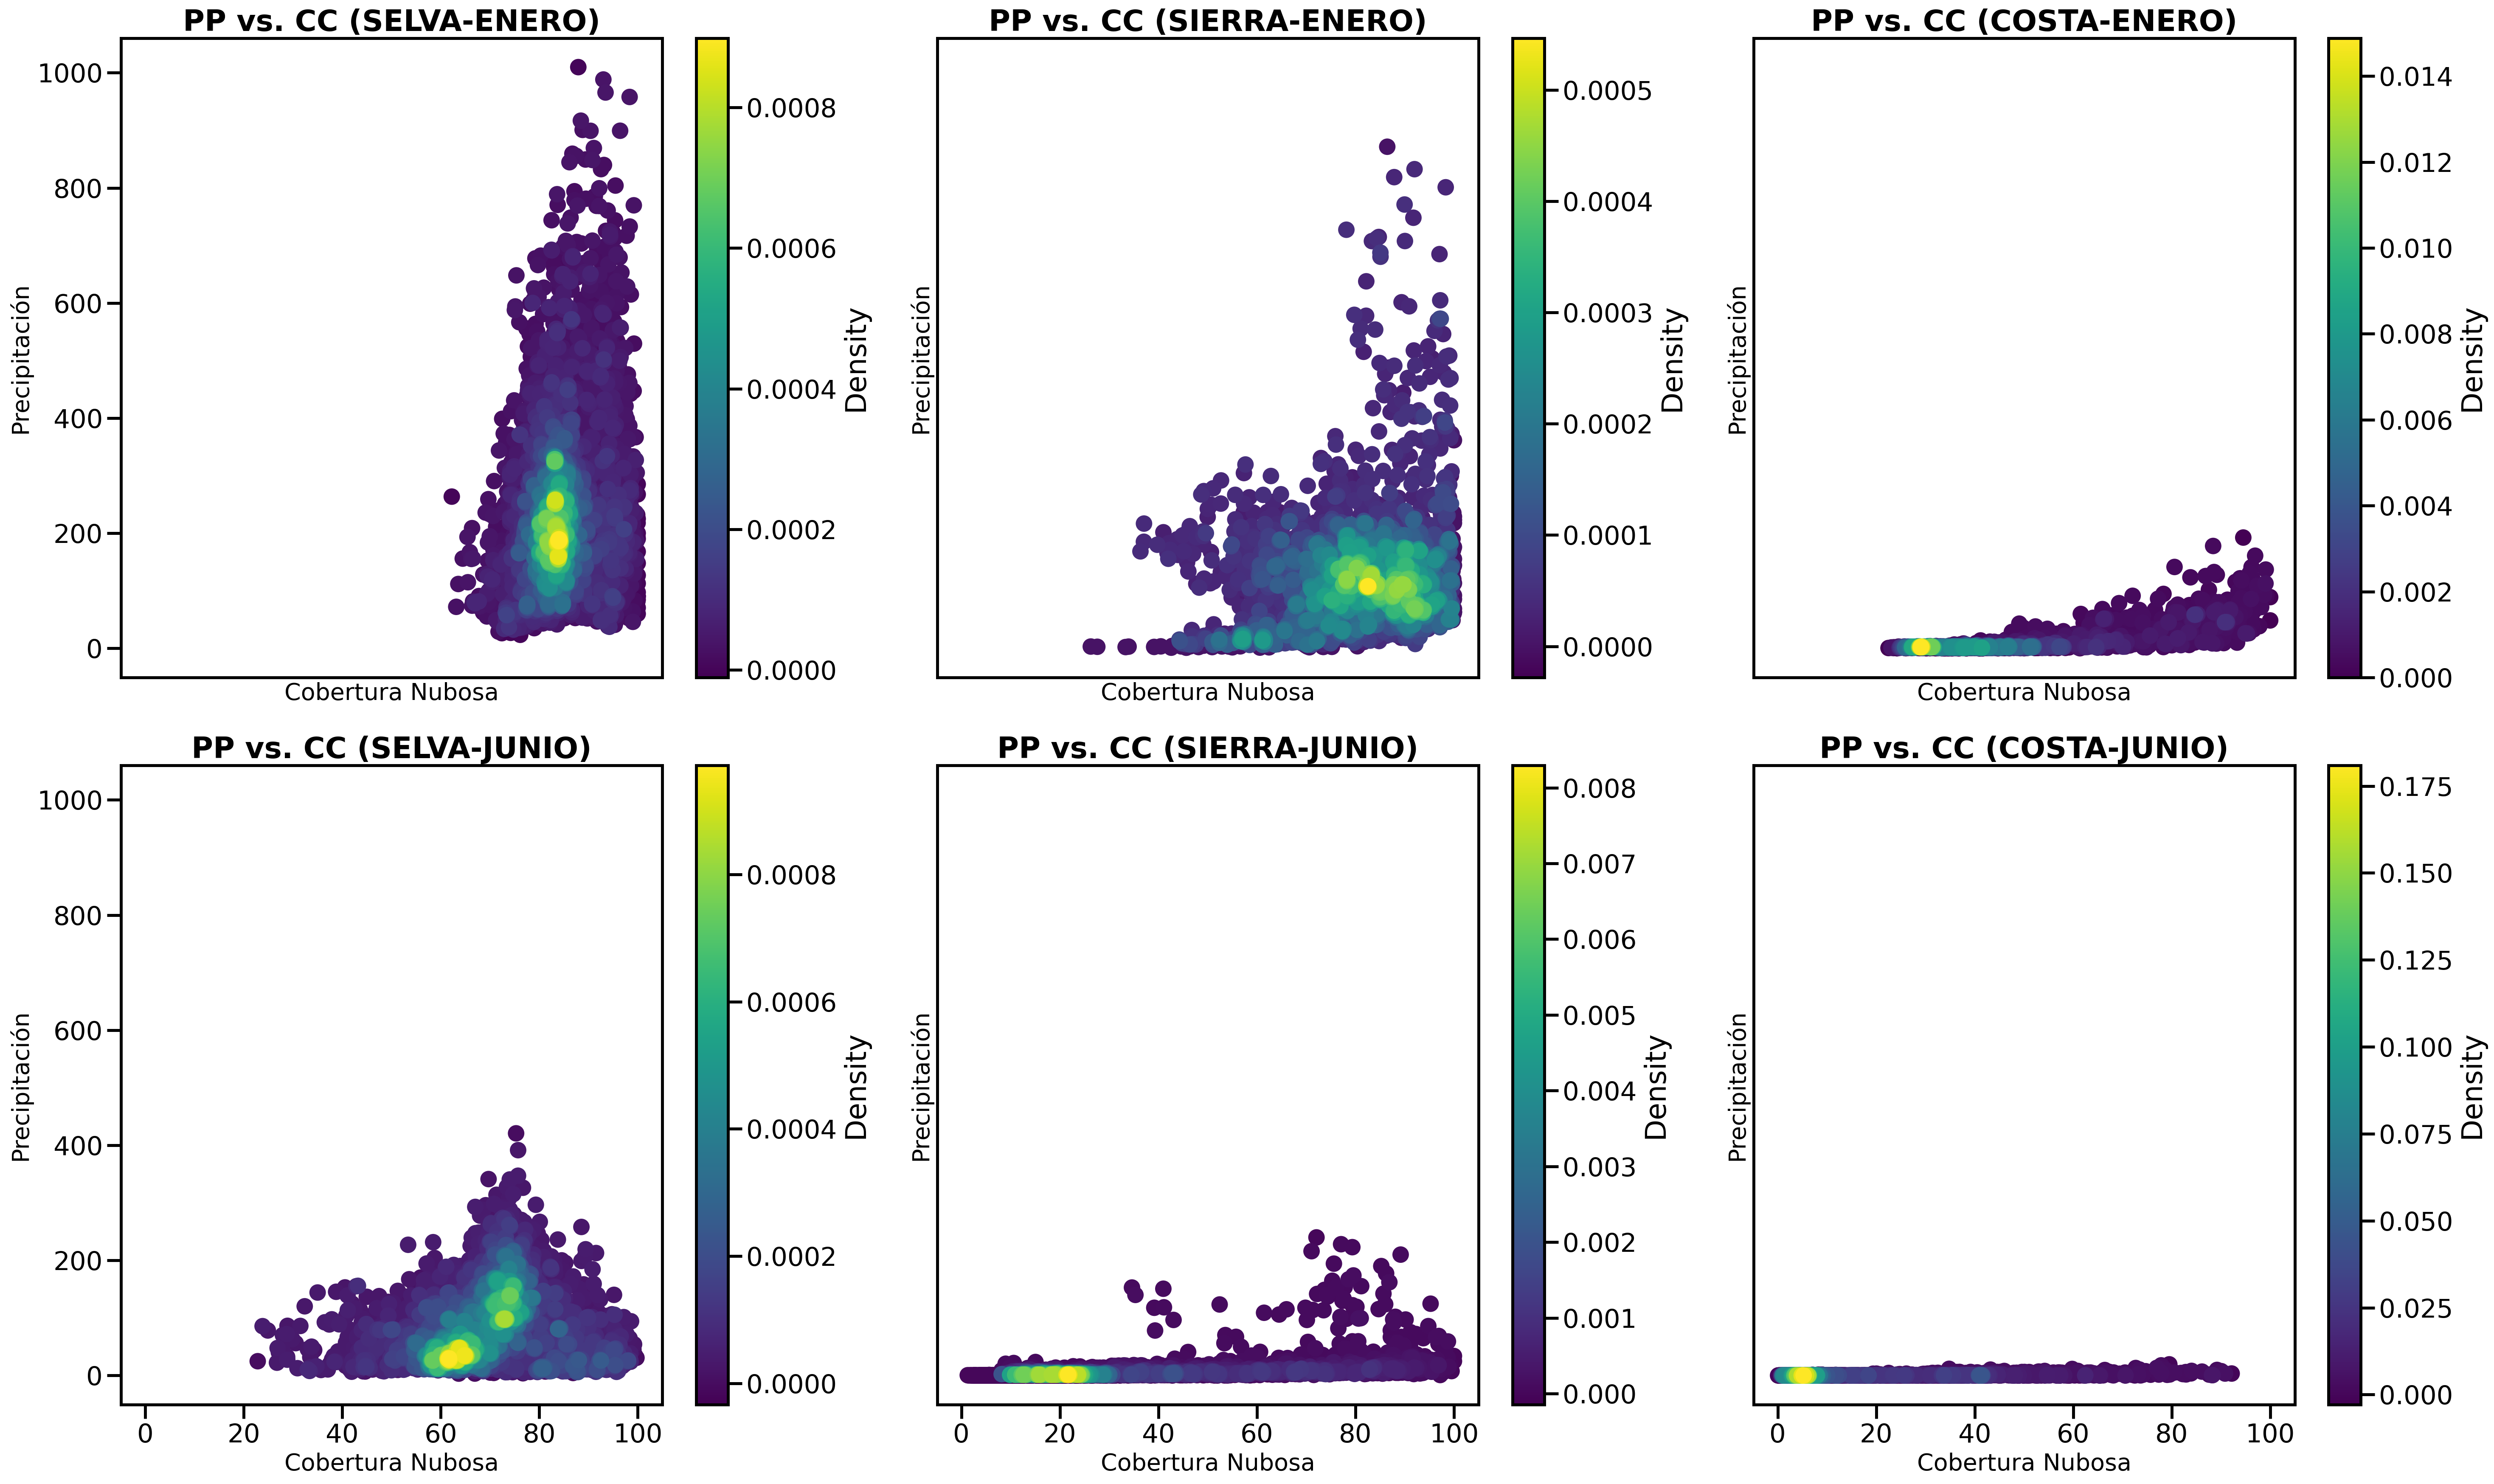

In [40]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 18), dpi = 200, sharex=True, sharey=True)

#plot figure 1
ax1.set_axisbelow(False)
x = CC_MASK_SELVA_interpolated.variable.isel(time=0).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (PISCO_PP_MASK_SELVA.isel(time=0)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z0 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurarse de plotear toda la data
z0[np.where(np.isnan(z0))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z0.argsort()
x, y, z0 = x[idx], y[idx], z0[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z0), vmax = np.max(z0))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax1)
cbar.ax.set_ylabel('Density')
#Edición de ejes
ax1.tick_params(bottom = False)
ax1.scatter( x, y, c=z0)
ax1.set_ylabel("Precipitación", fontsize = 20)
ax1.set_xlabel("Cobertura Nubosa", fontsize = 20)
ax1.set_title("PP vs. CC (SELVA-ENERO)", fontsize = 25,weight='bold')



#plotting figure 2
ax2.set_axisbelow(False)
x = CC_MASK_SIERRA_interpolated.variable.isel(time=0).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (PISCO_PP_MASK_SIERRA.isel(time=0)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z1 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurar de plotear toda la data
z1[np.where(np.isnan(z1))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z1.argsort()
x, y, z1 = x[idx], y[idx], z1[idx]
#Añadir Color bar
norm = Normalize(vmin = np.min(z1), vmax = np.max(z1))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax2)
cbar.ax.set_ylabel('Density')
#Edición de ejes
ax2.tick_params(bottom = False, left=False)
ax2.scatter( x, y, c=z1)
ax2.set_ylabel("Precipitación", fontsize = 20)
ax2.set_xlabel("Cobertura Nubosa", fontsize =  20)
ax2.set_title("PP vs. CC (SIERRA-ENERO)", fontsize = 25,weight='bold')


#plot figure 3
ax3.set_axisbelow(False)
x = CC_MASK_COSTA_interpolated.variable.isel(time=0).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (PISCO_PP_MASK_COSTA.isel(time=0)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z2 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurar que se plotee toda la data
z2[np.where(np.isnan(z2))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z2.argsort()
x, y, z2 = x[idx], y[idx], z2[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z2), vmax = np.max(z2))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax3)
cbar.ax.set_ylabel('Density')
#Edición de ejes
ax3.tick_params(bottom = False, left=False)
ax3.scatter( x, y, c=z2)
ax3.set_ylabel("Precipitación", fontsize = 20)
ax3.set_xlabel("Cobertura Nubosa", fontsize = 20)
ax3.set_title("PP vs. CC (COSTA-ENERO)", fontsize = 25,weight='bold')


#plot figure 4
ax4.set_axisbelow(False)
x = CC_MASK_SELVA_interpolated.variable.isel(time=5).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (PISCO_PP_MASK_SELVA.isel(time=5)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z3 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurarse de plotear toda la data
z3[np.where(np.isnan(z3))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z3.argsort()
x, y, z3 = x[idx], y[idx], z3[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z3), vmax = np.max(z3))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax4)
cbar.ax.set_ylabel('Density')
#Edición de ejes
ax4.scatter( x, y, c=z3)
ax4.set_ylabel("Precipitación", fontsize = 20)
ax4.set_xlabel("Cobertura Nubosa", fontsize = 20)
ax4.set_title("PP vs. CC (SELVA-JUNIO)", fontsize = 25,weight='bold')



#plotting figure 5
ax5.set_axisbelow(False)
x = CC_MASK_SIERRA_interpolated.variable.isel(time=5).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (PISCO_PP_MASK_SIERRA.isel(time=5)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z4 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurarnos de plotear toda la data
z4[np.where(np.isnan(z4))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z4.argsort()
x, y, z4 = x[idx], y[idx], z4[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z4), vmax = np.max(z4))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax5)
cbar.ax.set_ylabel('Density')
#edición de ejes
ax5.tick_params(left=False)
ax5.scatter( x, y, c=z4)
ax5.set_ylabel("Precipitación", fontsize = 20)
ax5.set_xlabel("Cobertura Nubosa", fontsize =  20)
ax5.set_title("PP vs. CC (SIERRA-JUNIO)", fontsize = 25,weight='bold')


#plot figure 6
ax6.set_axisbelow(False)
x = CC_MASK_COSTA_interpolated.variable.isel(time=5).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (PISCO_PP_MASK_COSTA.isel(time=5)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True)
z5 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurarnos de plotear toda la data
z5[np.where(np.isnan(z5))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z5.argsort()
x, y, z5 = x[idx], y[idx], z5[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z5), vmax = np.max(z5))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax6)
cbar.ax.set_ylabel('Density')
#edición de ejes
ax6.tick_params(left=False)
ax6.scatter( x, y, c=z5)
ax6.set_ylabel("Precipitación", fontsize = 20)
ax6.set_xlabel("Cobertura Nubosa", fontsize = 20)
ax6.set_title("PP vs. CC (COSTA-JUNIO)", fontsize = 25,weight='bold')

plt.tight_layout()
plt.savefig("DENSITY_SCATTER_PLOT_PP_CC.png")
plt.show()

In [41]:
WG_5 = xr.open_dataset("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/WGLC/wglc_climatology_05m.nc")
WG_5

<xarray.Dataset>
Dimensions:  (lon: 4320, lat: 2160, time: 12)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
  * time     (time) object 0000-01-01 00:00:00 ... 0000-12-01 00:00:00
Data variables:
    density  (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

In [42]:
WG_5=WG_5.rename({"lon":"longitude","lat":"latitude"})

In [43]:
WG_5=WG_5.density.interp_like(PISCOpp_monthly.isel(time=0),method="nearest")
WG_5=WG_5.to_dataset(name="density")

In [44]:
WG_5.rio.set_crs(shp_regselva.crs)
WG_5CRP=xr_crop(shp_i=shp_regselva,netcdf_i=WG_5)
#shape to grid
WG_5_grid=xr_shp_to_grid(shp_i = shp_regselva, netcdf_array = WG_5.density.isel(time=0))
#make a mask
WG_5MASK_selva=xr_mask(grid_mask=WG_5_grid, netcdf_i=WG_5CRP)


In [45]:
WG_5.rio.set_crs(shp_regsierra.crs)
WG_5CRP=xr_crop(shp_i=shp_regsierra,netcdf_i=WG_5)
#shape to grid
WG_5_grid=xr_shp_to_grid(shp_i = shp_regsierra, netcdf_array = WG_5.density.isel(time=0))
#make a mask
WG_5MASK_sierra=xr_mask(grid_mask=WG_5_grid, netcdf_i=WG_5CRP)


In [46]:
WG_5.rio.set_crs(shp_regcosta.crs)
WG_5CRP=xr_crop(shp_i=shp_regcosta,netcdf_i=WG_5)
#shape to grid
WG_5_grid=xr_shp_to_grid(shp_i = shp_regcosta, netcdf_array = WG_5.density.isel(time=0))
#make a mask
WG_5MASK_costa=xr_mask(grid_mask=WG_5_grid, netcdf_i=WG_5CRP)


In [47]:
WG_5MASK_selva=WG_5MASK_selva.drop_vars("spatial_ref")
WG_5MASK_sierra=WG_5MASK_sierra.drop_vars("spatial_ref")
WG_5MASK_costa=WG_5MASK_costa.drop_vars("spatial_ref")

In [48]:
WG_5MASK_selva["time"]=np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
WG_5MASK_sierra["time"]=np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
WG_5MASK_costa["time"]=np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
WG_5MASK_selva

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 173, longitude: 129)
Coordinates:
  * longitude  (longitude) float64 -79.38 -79.29 -79.21 ... -68.88 -68.79 -68.71
  * latitude   (latitude) float64 -14.46 -14.38 -14.29 ... -0.2083 -0.125
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    density    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

In [ ]:
WG_5MASK_sierra


<xarray.Dataset>
Dimensions:    (time: 12, latitude: 163, longitude: 133)
Coordinates:
  * longitude  (longitude) float64 -79.88 -79.79 -79.71 ... -69.04 -68.96 -68.88
  * latitude   (latitude) float64 -17.96 -17.88 -17.79 ... -4.625 -4.542 -4.458
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    density    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

In [ ]:
WG_5MASK_costa

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 179, longitude: 139)
Coordinates:
  * longitude  (longitude) float64 -81.29 -81.21 -81.12 ... -69.96 -69.88 -69.79
  * latitude   (latitude) float64 -18.29 -18.21 -18.12 ... -3.625 -3.542 -3.458
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    density    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

In [49]:
WG_5MASK_selva_interpolated=WG_5MASK_selva.density.interp_like(PISCO_PP_MASK_SELVA,method="nearest")
WG_5MASK_selva_interpolated=WG_5MASK_selva_interpolated.to_dataset()

In [50]:
WG_5MASK_sierra_interpolated=WG_5MASK_sierra.density.interp_like(PISCO_PP_MASK_SIERRA,method="nearest")
WG_5MASK_sierra_interpolated=WG_5MASK_sierra_interpolated.to_dataset()

In [51]:
WG_5MASK_costa_interpolated=WG_5MASK_costa.density.interp_like(PISCO_PP_MASK_COSTA,method="nearest")
WG_5MASK_costa_interpolated=WG_5MASK_costa_interpolated.to_dataset()

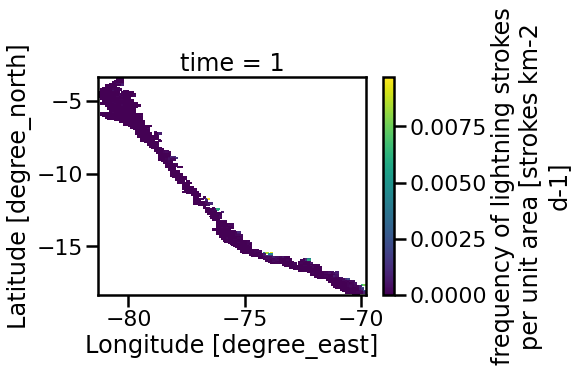

In [ ]:
WG_5MASK_costa_interpolated.density.isel(time=0).plot()

In [ ]:
WG_5MASK_costa_interpolated.density

<xarray.DataArray 'density' (time: 12, latitude: 149, longitude: 115)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
         1.2790825e-04, 3.8066081e-04, 2.4306872e-03],
        [          nan,           nan,           nan, ...,
         7.9648387e-05, 0.0000000e+00, 8.6124067e-04],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
...
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -70.05 -69.95 -69.85
  * latitude   (latitude) float32 -3.45 -3.55 -3.65 ... -18.05 -18.15 -18.25
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  frequency of lightning strokes per unit area
    units:      strokes km-2 d-1

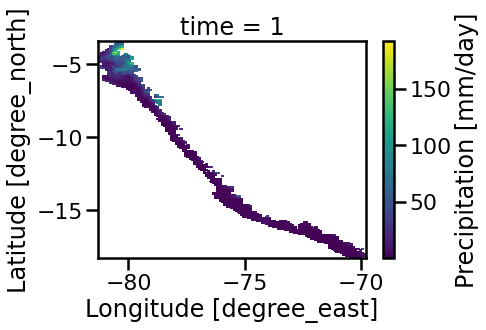

In [ ]:
PISCO_PP_MASK_COSTA.isel(time=0).plot()

In [ ]:
PISCO_PP_MASK_COSTA

<xarray.DataArray 'Prec' (time: 12, latitude: 149, longitude: 115)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  6.9043202 ,
         11.658789  , 14.872147  ],
        [        nan,         nan,         nan, ...,  2.6914685 ,
          7.1521244 , 12.616795  ],
        [        nan,         nan,         nan, ...,  2.5639064 ,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,  0.44271234,
          0.5018339 ,  0.6379173 ],
        [        nan,         nan,         nan, ...,  0.48854017,
          0.57036406,  0.6599199 ],
        [        nan,         nan,         nan, ...,  0.62915343,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  1.1387844 ,
          1.3120368 ,  3.5610049 ],
        [        nan,         nan,         nan, ...,  1.1596566 ,
          1.2903053 ,  1.5259672 ],
        [        nan,         nan,         nan, ...,  1.2072009 ,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -3.45 -3.55 -3.65 ... -18.05 -18.15 -18.25
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -70.05 -69.95 -69.85
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

Text(0.5, 0, 'Incidencia de rayos')

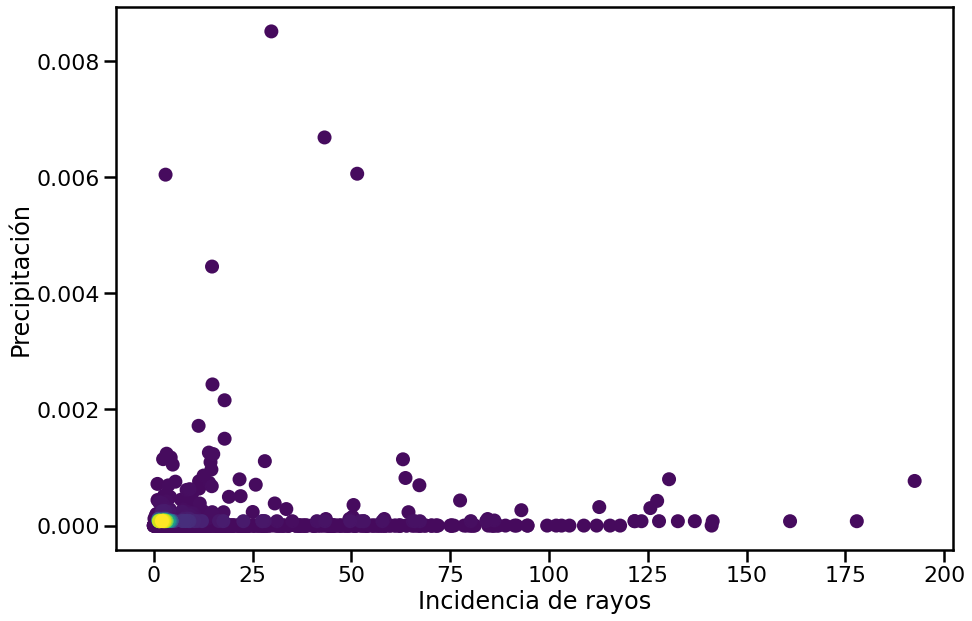

In [52]:
#PARA LA COSTA PP VS. WG

fig, ax0 = plt.subplots(1, 1, figsize = (15, 10), sharey = True)

x = PISCO_PP_MASK_COSTA.isel(time=0).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (WG_5MASK_costa_interpolated.density.isel(time=0)).to_numpy().ravel()
y = y[~np.isnan(y)]

data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z0 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

#To be sure to plot all data
z0[np.where(np.isnan(z0))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z0.argsort()
x, y, z0 = x[idx], y[idx], z0[idx]

ax0.scatter( x, y, c=z0)
ax0.set_ylabel("Precipitación")
ax0.set_xlabel("Incidencia de rayos")

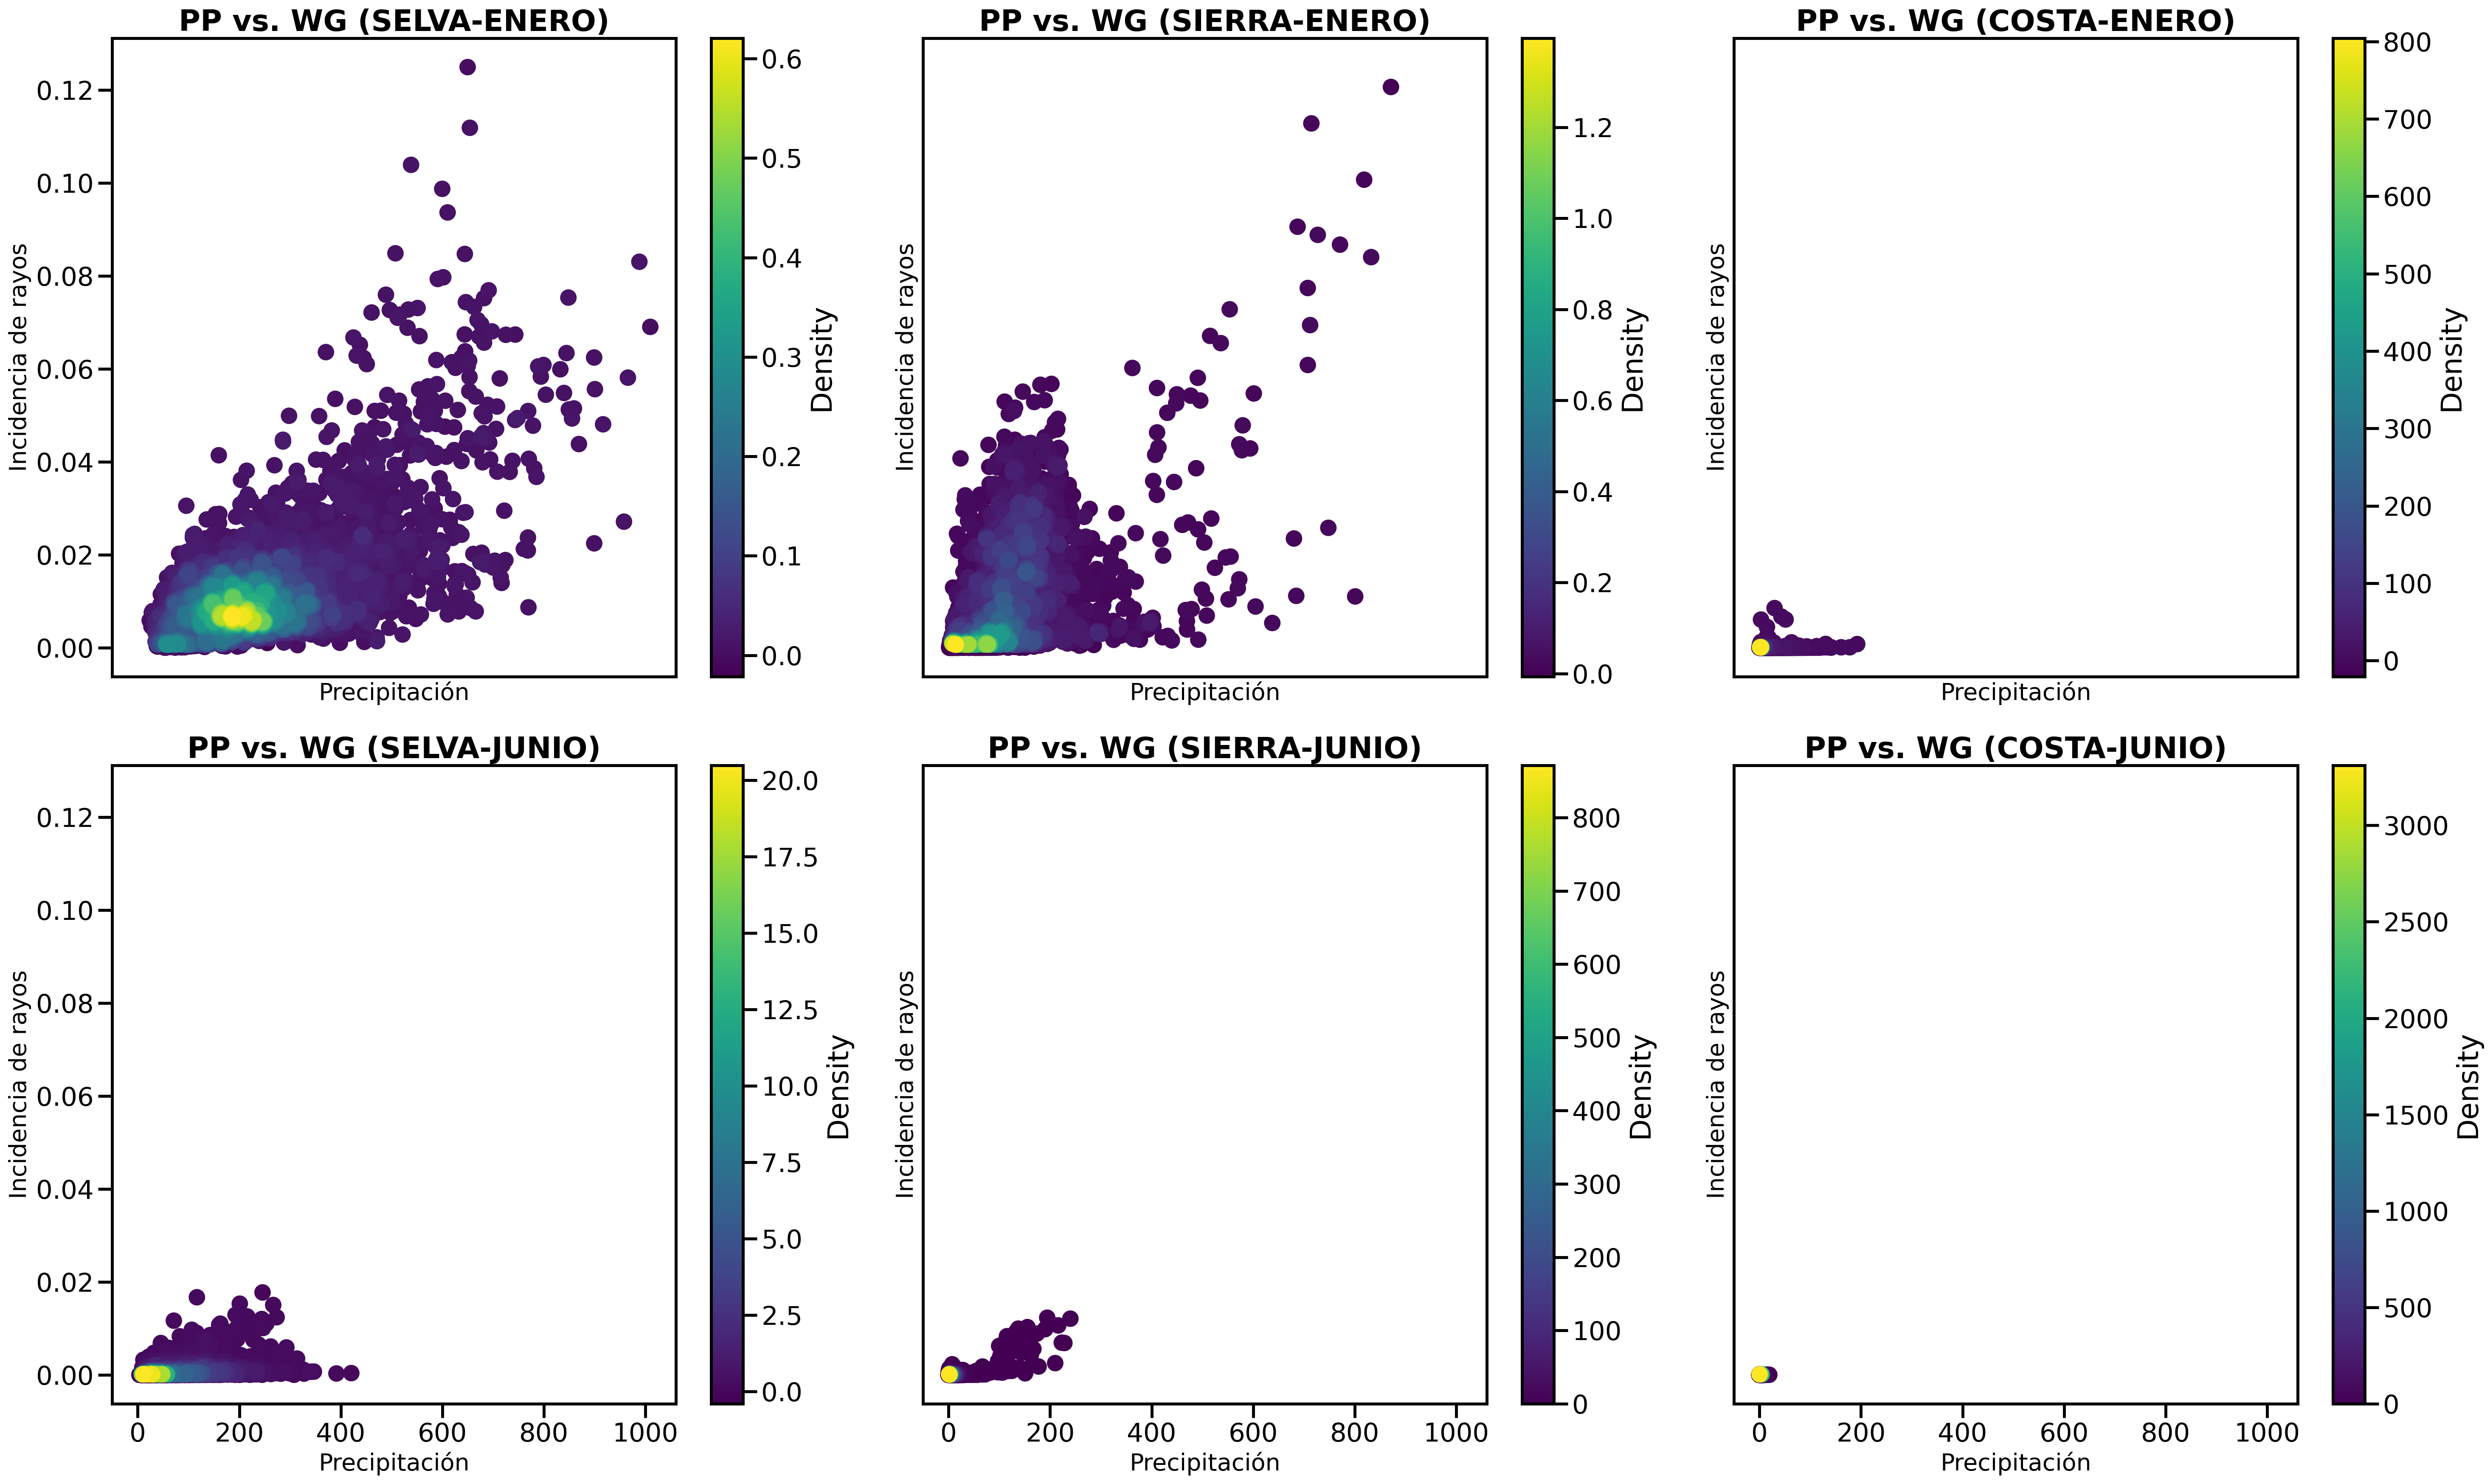

In [53]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 18), dpi = 200, sharex=True, sharey=True)

#plot figure 1
ax1.set_axisbelow(False)
x = (PISCO_PP_MASK_SELVA.isel(time=0)).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (WG_5MASK_selva_interpolated.density.isel(time=0)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z0 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurarse de plotear toda la data
z0[np.where(np.isnan(z0))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z0.argsort()
x, y, z0 = x[idx], y[idx], z0[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z0), vmax = np.max(z0))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax1)
cbar.ax.set_ylabel('Density')
#Edición de ejes
ax1.tick_params(bottom = False)
ax1.scatter( x, y, c=z0)
ax1.set_ylabel("Incidencia de rayos", fontsize = 20)
ax1.set_xlabel("Precipitación", fontsize = 20)
ax1.set_title("PP vs. WG (SELVA-ENERO)", fontsize = 25,weight='bold')



#plotting figure 2
ax2.set_axisbelow(False)
x = (PISCO_PP_MASK_SIERRA.isel(time=0)).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (WG_5MASK_sierra_interpolated.density.isel(time=0)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z1 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurar de plotear toda la data
z1[np.where(np.isnan(z1))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z1.argsort()
x, y, z1 = x[idx], y[idx], z1[idx]
#Añadir Color bar
norm = Normalize(vmin = np.min(z1), vmax = np.max(z1))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax2)
cbar.ax.set_ylabel('Density')
#Edición de ejes
ax2.tick_params(bottom = False, left=False)
ax2.scatter( x, y, c=z1)
ax2.set_ylabel("Incidencia de rayos", fontsize = 20)
ax2.set_xlabel("Precipitación", fontsize =  20)
ax2.set_title("PP vs. WG (SIERRA-ENERO)", fontsize = 25,weight='bold')


#plot figure 3
ax3.set_axisbelow(False)
x = (PISCO_PP_MASK_COSTA.isel(time=0)).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (WG_5MASK_costa_interpolated.density.isel(time=0)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z2 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurar que se plotee toda la data
z2[np.where(np.isnan(z2))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z2.argsort()
x, y, z2 = x[idx], y[idx], z2[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z2), vmax = np.max(z2))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax3)
cbar.ax.set_ylabel('Density')
#Edición de ejes
ax3.tick_params(bottom = False, left=False)
ax3.scatter( x, y, c=z2)
ax3.set_ylabel("Incidencia de rayos", fontsize = 20)
ax3.set_xlabel("Precipitación", fontsize = 20)
ax3.set_title("PP vs. WG (COSTA-ENERO)", fontsize = 25,weight='bold')


#plot figure 4
ax4.set_axisbelow(False)
x = (PISCO_PP_MASK_SELVA.isel(time=5)).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (WG_5MASK_selva_interpolated.density.isel(time=5)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z3 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurarse de plotear toda la data
z3[np.where(np.isnan(z3))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z3.argsort()
x, y, z3 = x[idx], y[idx], z3[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z3), vmax = np.max(z3))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax4)
cbar.ax.set_ylabel('Density')
#Edición de ejes
ax4.scatter( x, y, c=z3)
ax4.set_ylabel("Incidencia de rayos", fontsize = 20)
ax4.set_xlabel("Precipitación", fontsize = 20)
ax4.set_title("PP vs. WG (SELVA-JUNIO)", fontsize = 25,weight='bold')



#plotting figure 5
ax5.set_axisbelow(False)
x = (PISCO_PP_MASK_SIERRA.isel(time=5)).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (WG_5MASK_sierra_interpolated.density.isel(time=5)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True )
z4 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurarnos de plotear toda la data
z4[np.where(np.isnan(z4))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z4.argsort()
x, y, z4 = x[idx], y[idx], z4[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z4), vmax = np.max(z4))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax5)
cbar.ax.set_ylabel('Density')
#edición de ejes
ax5.tick_params(left=False)
ax5.scatter( x, y, c=z4)
ax5.set_ylabel("Incidencia de rayos", fontsize = 20)
ax5.set_xlabel("Precipitación", fontsize =  20)
ax5.set_title("PP vs. WG (SIERRA-JUNIO)", fontsize = 25,weight='bold')


#plot figure 6
ax6.set_axisbelow(False)
x = (PISCO_PP_MASK_COSTA.isel(time=5)).to_numpy().ravel()
x = x[~np.isnan(x)]
y = (WG_5MASK_costa_interpolated.density.isel(time=5)).to_numpy().ravel()
y = y[~np.isnan(y)]
#
data , x_e, y_e = np.histogram2d( x, y, bins =[100,100], density = True)
z5 = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#Asegurarnos de plotear toda la data
z5[np.where(np.isnan(z5))] = 0.0
#Ordenar los puntos para que se muestre el más denso sobre los menos densos
idx = z5.argsort()
x, y, z5 = x[idx], y[idx], z5[idx]
#Añadir color bar
norm = Normalize(vmin = np.min(z5), vmax = np.max(z5))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax6)
cbar.ax.set_ylabel('Density')
#edición de ejes
ax6.tick_params(left=False)
ax6.scatter( x, y, c=z5)
ax6.set_ylabel("Incidencia de rayos", fontsize = 20)
ax6.set_xlabel("Precipitación", fontsize = 20)
ax6.set_title("PP vs. WG (COSTA-JUNIO)", fontsize = 25,weight='bold')

plt.tight_layout()
plt.savefig("DENSITY_SCATTER_PLOT_PP_WG.png")
plt.show()